## Data Preprocessing

In [1]:
import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the data set
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

In [5]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping])

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 312s 329ms/step - loss: 0.0551 - val_loss: 0.0158
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 308s 328ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 328s 334ms/step - loss: 0.0117 - val_loss: 0.0130


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step


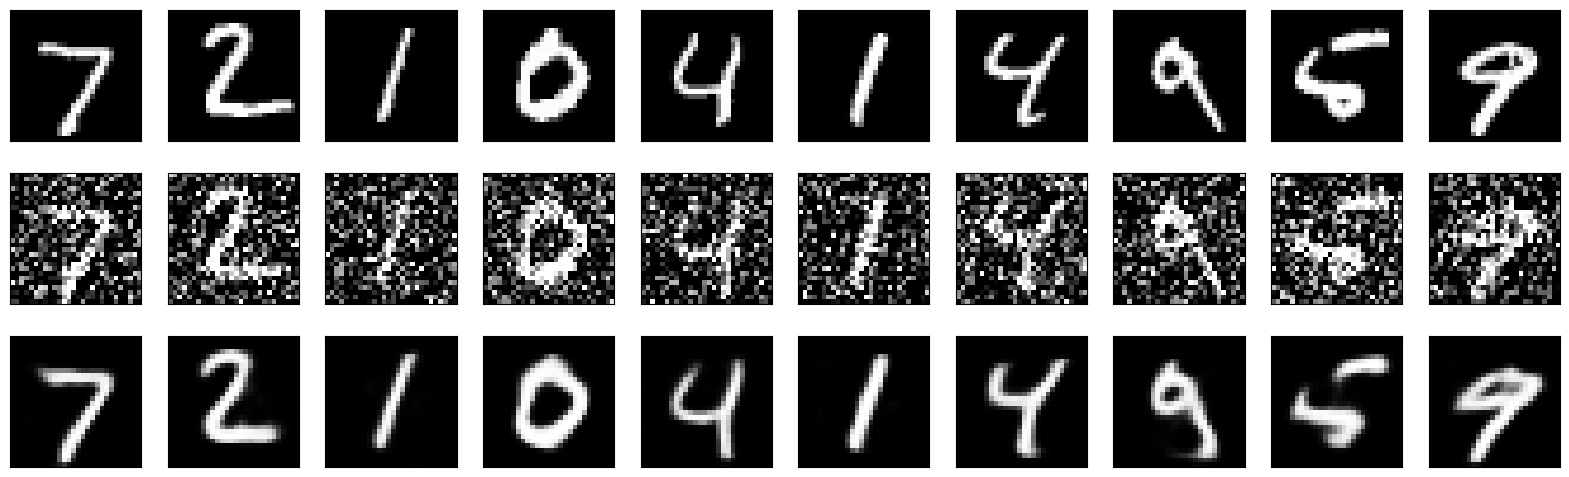

In [6]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
# Freeze all the layers
for layer in diffusion_model.layers:
    layer.trainable = False

In [8]:
# Check trainable status of each layer
for i, layer in enumerate(diffusion_model.layers):
    print(f"Layer {i}: {layer.name} — Trainable: {layer.trainable}")

Layer 0: input_layer — Trainable: False
Layer 1: conv2d — Trainable: False
Layer 2: conv2d_1 — Trainable: False
Layer 3: flatten — Trainable: False
Layer 4: dense — Trainable: False
Layer 5: dense_1 — Trainable: False
Layer 6: reshape — Trainable: False
Layer 7: conv2d_transpose — Trainable: False
Layer 8: conv2d_transpose_1 — Trainable: False
Layer 9: conv2d_2 — Trainable: False


In [9]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 227s 240ms/step - loss: 0.0947 - val_loss: 0.0965
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 255s 233ms/step - loss: 0.0934 - val_loss: 0.0963
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 234ms/step - loss: 0.0932 - val_loss: 0.0961
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 234ms/step - loss: 0.0929 - val_loss: 0.0961
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 234ms/step - loss: 0.0931 - val_loss: 0.0961
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 234ms/step - loss: 0.0926 - val_loss: 0.0961
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 234ms/step - loss: 0.0927 - val_loss: 0.0957
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 235ms/step - loss: 0.0925 - val_loss: 0.0963
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 234ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 262s 234ms/step - loss: 0.0926 - val_loss: 0.0957


In [12]:
# Modify the noise factor to 0.3
noise_factor = 0.3

# Add noise to the data with the new noise factor
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model
diffusion_model.fit(x_train_noisy, x_train, epochs=3, batch_size=128, shuffle=True,validation_data=(x_test_noisy, x_test))

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 424ms/step - loss: 0.0843 - val_loss: 0.0840
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 421ms/step - loss: 0.0843 - val_loss: 0.0839
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 420ms/step - loss: 0.0842 - val_loss: 0.0838


In [14]:
# Define the modified diffusion model architecture with additional layers
input_layer = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)

# Compile the model
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model
diffusion_model.summary()

# Train the model
diffusion_model.fit(x_train_noisy, x_train, epochs=3, batch_size=128, shuffle=True, validation_data=(x_test_noisy, x_test))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50176)          │     6,472,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,576,961 (74.68 MB)

 Trainable params: 19,576,961 (74.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2156s 5s/step - loss: 0.2109 - val_loss: 0.0870
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2213s 5s/step - loss: 0.0864 - val_loss: 0.0836
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 2243s 5s/step - loss: 0.0824 - val_loss: 0.0808


313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 326ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 99s 318ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 321ms/step


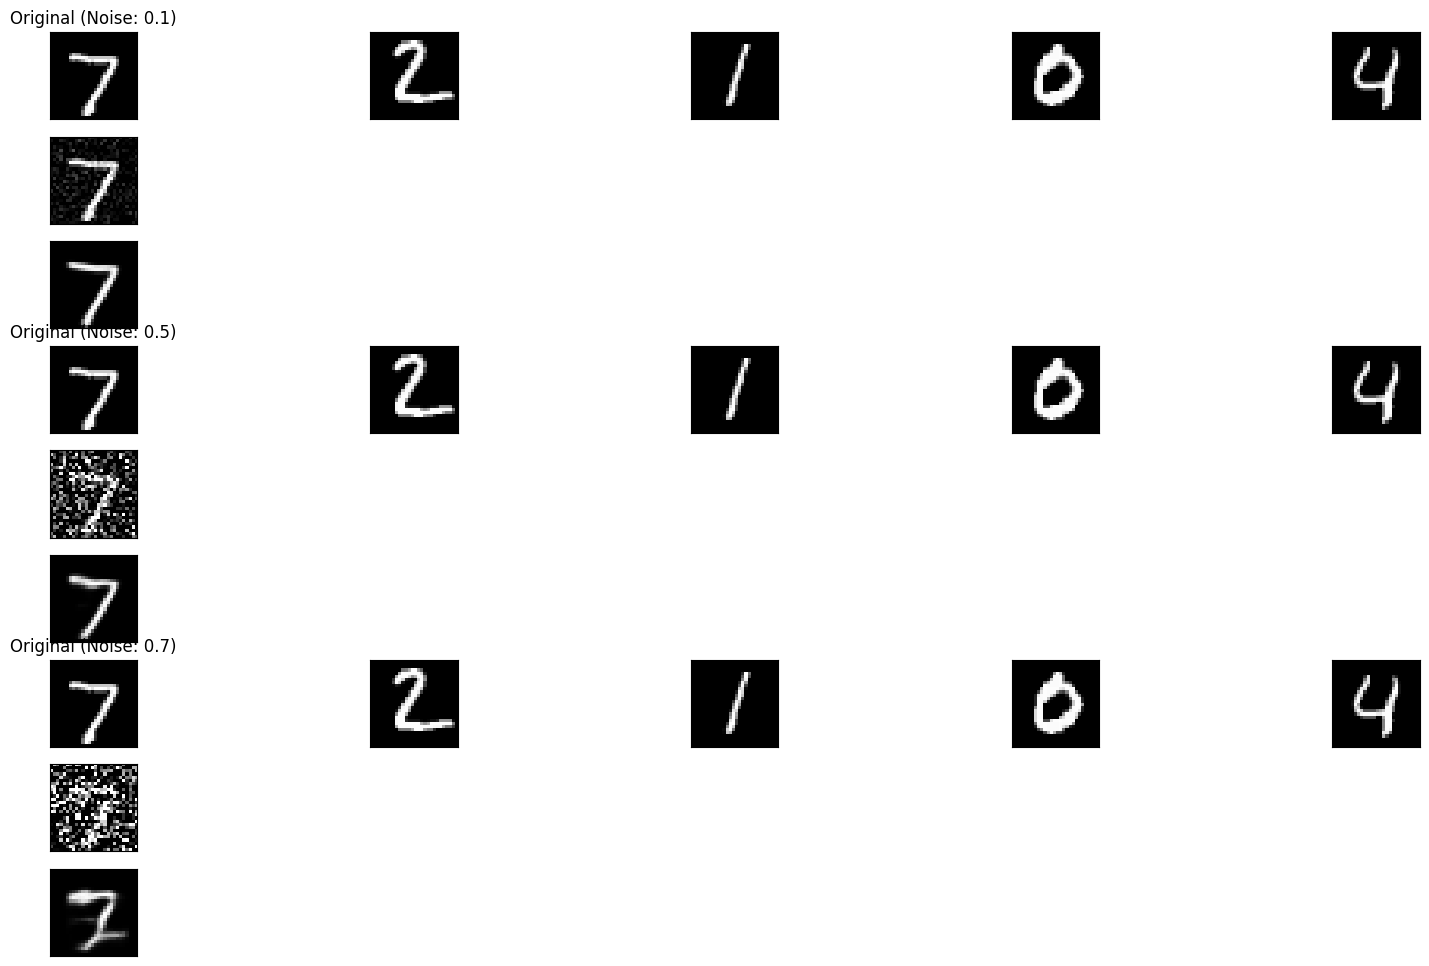

In [15]:
import matplotlib.pyplot as plt

# Function to add noise and predict denoised images
def add_noise_and_predict(noise_factor):
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
  x_test_noisy = np.clip(x_test_noisy, 0., 1.)
  denoised_images = diffusion_model.predict(x_test_noisy)
  return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]
# Visualize the results
n = 5 # Number of digits to display
plt.figure(figsize=(20, 12))
for idx, noise_factor in enumerate(noise_levels):
  x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)
  for i in range(n):
    # Display original
    ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if i == 0:
      ax.set_title(f'Original (Noise: {noise_factor})')
      # Display noisy
      ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
      plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      # Display denoised
      ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
      plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
plt.show()